In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rrcf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read csv file
df_pH = pd.read_csv("Data_Raw_Water.csv")
print('The number of samples of the data ', len(df_pH))
df_pH.head()

The number of samples of the data  2658


,time,turbidity,pH
0,2020-11-04 11:00:31.822439+00:00,21.063435,7.34
1,2020-11-04 11:01:22.124333+00:00,20.868153,7.33
2,2020-11-04 11:01:51.663062+00:00,20.584553,7.32
3,2020-11-04 11:02:29.373718+00:00,21.185328,7.33
4,2020-11-04 11:03:45.517010+00:00,21.063435,7.32


In [3]:
# Convert dataframe to array
pH_train= np.array(df_pH['pH'])

In [4]:
# Set tree parameters
num_trees = 30
shingle_size = 1
tree_size = 200


In [5]:
# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)


In [6]:
# Use the "shingle" generator to create rolling window
points = rrcf.shingle(pH_train, size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

In [7]:
%%time
# Display prediction result

for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size, drop the oldest point
        # (FIFO)
        if len(tree.leaves) > tree_size:
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point and take the average among
        # all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees

Wall time: 3min 14s


In [8]:
# Convert score dictionary to data frame.
pH_result = pd.DataFrame.from_dict(avg_codisp,'index')

In [9]:
# Merge score with data.
df_pH['Score'] = pH_result

In [36]:
#Try different values of threshold to get anomalies.
anomalies = df_pH.loc[df_pH['Score']>42]
anomalies_only = anomalies[['time', 'pH', 'Score']]
anomalies_only

,time,pH,Score
319,2020-11-11 23:15:16.261228+00:00,7.36,42.030912
350,2020-11-12 23:28:06.931813+00:00,7.36,42.240287
360,2020-11-13 04:30:47.477089+00:00,7.36,42.215163
371,2020-11-13 10:03:44.075480+00:00,7.36,42.617862
382,2020-11-13 16:06:56.725913+00:00,7.36,43.712562
...,...,...,...
2023,2020-12-21 17:45:51.270365+00:00,7.33,59.133333
2052,2020-12-22 08:14:04.352614+00:00,7.31,84.715904
2332,2020-12-28 06:24:47.400626+00:00,7.39,79.947436
2604,2021-01-03 06:21:47.632755+00:00,7.40,86.307143


In [37]:
len(anomalies)

77

Text(0.5, 1.0, 'Water pH data (Red) and Anomaly Score (Blue)\n')

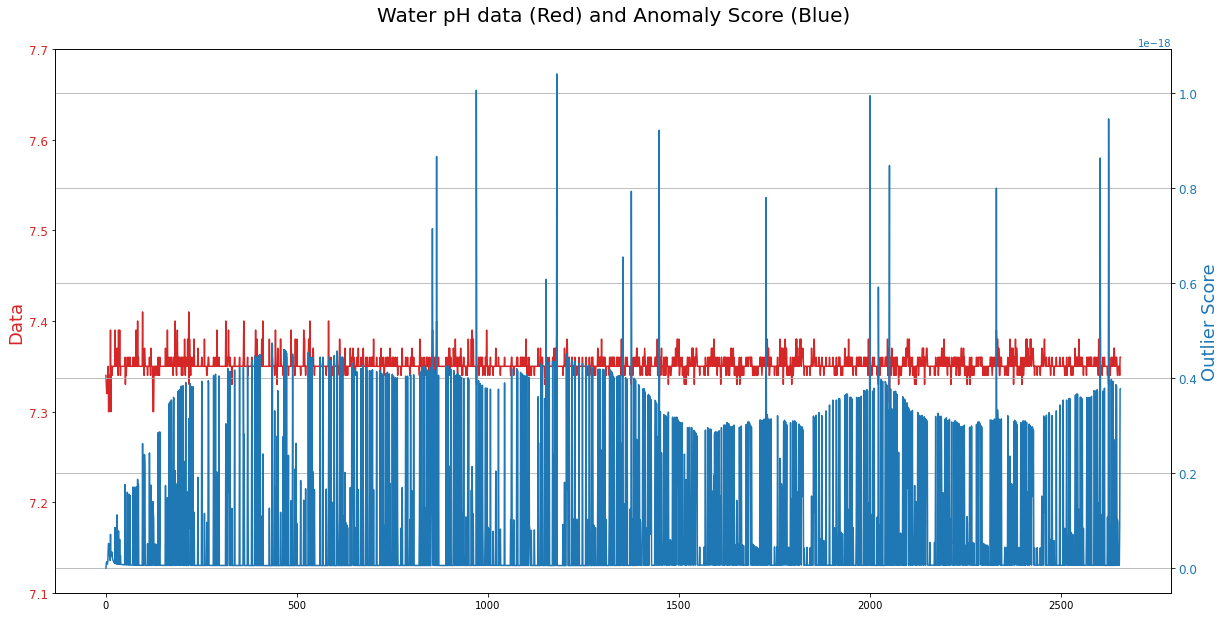

In [38]:
for index in range(len(avg_codisp)):
    avg_codisp[index]=avg_codisp[index]/100
    
fig, ax1 = plt.subplots(figsize=(20, 10))
color = 'tab:red'
ax1.set_ylabel('Data', color=color, size=18)
ax1.plot(pH_train, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.set_ylim(7.1,7.7)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Outlier Score', color=color, size=18)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid('off')
#ax2.set_ylim(0,100)
plt.title('Water pH data (Red) and Anomaly Score (Blue)\n', size=20)